In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from fuzzywuzzy import fuzz
import geopandas as gpd

MCS_DATA_PATH = "../../data/external/Solar PV installations west midlands.xlsx"
test_df = pd.read_excel(MCS_DATA_PATH, sheet_name="Sheet3")

# Standardise postcode for grouping 
test_df['Postcode'] = test_df['Postcode'].str.upper()
test_df = test_df[test_df['Postcode'].isna()==False]

# Add full address
test_add_cols = ['Address Line 1', 'Address Line 2', 'Address Line 3']
test_df[test_add_cols] = test_df[test_add_cols].fillna('')
test_df['full_address'] = test_df[test_add_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

c:\Users\lilia\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
def add_full_address(db):
    """
    Add 'full_address' column for predicted solar pv files

        """
    db['buildingNumber'] = db['buildingNumber'].astype('Int64').astype(str)
    db['buildingNumber'] = db['buildingNumber'].str.replace("<NA>", "")
    db['postcode'] = db['postcode'].str.replace(r"\s", "")

    results_add_cols = ['buildingNumber', 'thoroughfare']
    db[results_add_cols] = db[results_add_cols].fillna('')
    db['full_address'] = db[results_add_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    db = db[db['full_address'] !='']

    return db

In [3]:
def get_test_set(test_df, train_df):
    """
    Match houses from MCS data to houses from OSMap data

    Input
    test_df(DataFrame)
    train_df(DataFrame)

    Output
    matched_uprn(DataFrame): PV outputs for matching UPRNs 
    
    """
    unq_postcode = list(train_df.postcode.unique())

    uprn = {}
    mapped_add = {}
    score = {}
    for postcode, grp in test_df.groupby('Postcode'): 
        if postcode in unq_postcode:
            sub_results = train_df[train_df.postcode==postcode]
            for i in grp.index:
                if sub_results['full_address'].shape[0]:
                    fuzz_score = [fuzz.partial_ratio(grp['full_address'][i], add) for add in sub_results['full_address']]
                    idx = sub_results.index[np.argmax(np.array(fuzz_score))]
                    if max(fuzz_score) > 80:
                        uprn[i] = sub_results['uprn'][idx]
                        mapped_add[i] = sub_results['full_address'][idx]
                        score[i] = max(fuzz_score)

    matched_uprn = test_df.loc[uprn.keys()]
    matched_uprn['uprn'] = uprn.values()
    matched_uprn['mapped_address'] = mapped_add.values()
    matched_uprn['score'] = score.values()

    if len(matched_uprn) > 0:
        matched_uprn = matched_uprn.merge(
            train_df, 
            how='left', on='uprn'
            )
    else:
        print("No matches")

    return matched_uprn

In [4]:
# Estimated solar PV output for buildings with no DSM
# Method: pv_lib
pvlib_building = pd.DataFrame(gpd.read_file("../02_calc_pv_output/output/building_pv.geojson", driver='GeoJSON'))
pvlib_building = add_full_address(pvlib_building)
data = get_test_set(test_df, pvlib_building)
data[['Estimated Annual Generation', 'pv_output']].describe()


C:\Users\lilia\AppData\Local\Temp\ipykernel_24628\2224345721.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  db['postcode'] = db['postcode'].str.replace(r"\s", "")


,Estimated Annual Generation,pv_output
count,584.000,584.000
mean,2999.697,20351.907
std,3819.842,120788.294
min,1.820,72.542
25%,1549.750,3680.331
50%,2544.500,5427.185
75%,3242.500,8379.753
max,42090.000,2340706.862


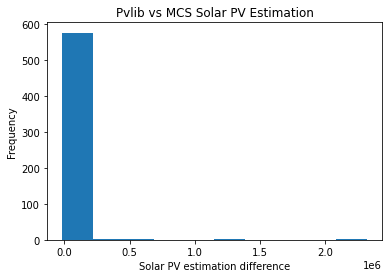

In [5]:
import matplotlib.pyplot as plt
plt.hist(data['pv_output'] - data['Estimated Annual Generation'], bins=10)
plt.xlabel('Solar PV estimation difference')
plt.ylabel('Frequency')
plt.title('Pvlib vs MCS Solar PV Estimation')
plt.show()

In [6]:
data['pv_output'] - data['Estimated Annual Generation']

0      4120.332
1      9901.840
2     17833.710
3     17628.710
4      2223.403
         ...   
579    4676.884
580    3869.122
581    5019.799
582    7636.721
583    4573.815
Length: 584, dtype: float64

In [10]:
# Estimated solar panel output for roof segments
# Method: pvlib
pvlib_roof_segment = pd.read_csv("../02_calc_pv_output/output/roof_segment_pv.csv")
pvlib_roof_segment = add_full_address(pvlib_roof_segment)
data = get_test_set(test_df, pvlib_roof_segment)

C:\Users\lilia\AppData\Local\Temp\ipykernel_7400\2224345721.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  db['postcode'] = db['postcode'].str.replace(r"\s", "")


No matches


In [11]:
pvlib_roof_segment

,uprn,lat,lng,slope_mean,aspect_mean,shading_mean,height_mean,pv_output,thoroughfare,postcode,buildingNumber,parentUPRN,AREA,full_address
0,10007123947.000,52.600,-2.137,55.371,0.248,0.458,126.810,209673.706,GORSEBROOK ROAD,WV60PD,117,100071565541.000,5.966,117 GORSEBROOK ROAD
1,100071353154.000,52.598,-2.138,25.756,5.799,0.708,127.251,587634.217,DUNSTALL ROAD,WV60PA,5,100071583636.000,6.601,5 DUNSTALL ROAD
2,100071353155.000,52.598,-2.138,25.756,5.799,0.708,127.251,587634.217,DUNSTALL ROAD,WV60PA,6,100071583636.000,6.601,6 DUNSTALL ROAD
3,100071353412.000,52.600,-2.137,55.371,0.248,0.458,126.810,209673.706,GORSEBROOK ROAD,WV60PD,117,100071565541.000,5.966,117 GORSEBROOK ROAD
4,100071353413.000,52.600,-2.137,55.371,0.248,0.458,126.810,209673.706,GORSEBROOK ROAD,WV60PD,117,100071565541.000,5.966,117 GORSEBROOK ROAD


In [22]:
# Estimated solar PV output for roof segments
# Method: MCS
MCS_pv_output = pd.read_csv("../02_calc_pv_output/output/MCS_pv_output.csv")
MCS_pv_output = add_full_address(MCS_pv_output)
data = get_test_set(test_df, MCS_pv_output)

C:\Users\lilia\AppData\Local\Temp\ipykernel_20960\2224345721.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  db['postcode'] = db['postcode'].str.replace(r"\s", "")


No matches


In [90]:
pv_output['parentUPRN'] = pv_output['uprn'].map(mapping)

In [29]:
nested_buildings = pvlib_roof_segment[pvlib_roof_segment['parentUPRN'].isna()==False]
nested_buildings.groupby('parentUPRN').sum()['pv_output'].describe()

count         2.000
mean     902144.776
std      386255.180
min      629021.119
25%      765582.948
50%      902144.776
75%     1038706.605
max     1175268.434
Name: pv_output, dtype: float64

In [106]:
unnested_buildings = pv_output[pv_output['parentUPRN'].isna()==True]
unnested_buildings.groupby('uprn').sum()['AC'].describe()

count       441.000000
mean      36829.340972
std       38288.158250
min        2010.391400
25%       12739.773021
50%       26551.113135
75%       43270.215642
max      273287.769168
Name: AC, dtype: float64

In [83]:
pv_output.groupby('uprn').sum()['AC'].describe()

count       475.000000
mean      50141.708143
std       66379.975122
min        2010.391400
25%       13017.885623
50%       28512.724403
75%       46910.120384
max      273287.769168
Name: AC, dtype: float64

In [70]:
test_df['Estimated Annual Generation'].describe()

count    6.028200e+04
mean     2.439131e+07
std      5.987197e+09
min      0.000000e+00
25%      1.200000e+03
50%      2.439000e+03
75%      3.286400e+03
max      1.470000e+12
Name: Estimated Annual Generation, dtype: float64